<a href="https://colab.research.google.com/github/shapi88/tensorflow_book/blob/main/06_transfer_learning_in_tensorflow_part_3_scaling_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)


We've seen the power of transfer learning feature extraction and fine-tuning, now it's time to scale up to all of the classes in Food101 (101 total classes of food).


Our goal is to beat the original Food101 paper with 10% of the training (leveraging the power of deep learning).


Original Food101 paper: https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/static/bossard_eccv14_food-101.pdf


Our baseline to beat is 50.76% accuracy across 101 classes.


-------------------------------------------------------------------
See full course materials on GitHub: https://github.com/mrdbourke/tensorflow-deep-learning

In [ ]:
# Check to see if we're using a GPU
!nvidia-smi

Fri Jun 30 08:47:37 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    24W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Creating helper functions

In previous notebooks, we've created a series of helper functions to do different tasks, let's download them.

In [ ]:
!wget https://raw.githubusercontent.com/shapi88/tensorflow_book/main/helpers/helpers.py

--2023-06-30 08:47:37--  https://raw.githubusercontent.com/shapi88/tensorflow_book/main/helpers/helpers.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10245 (10K) [text/plain]
Saving to: ‘helpers.py’

helpers.py          100%[===================>]  10.00K  --.-KB/s    in 0s      

2023-06-30 08:47:37 (101 MB/s) - ‘helpers.py’ saved [10245/10245]



In [ ]:
# Import helper functions we're going to use in this notebook
from helpers import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir
import tensorflow as tf

### 101 Food Classes: working with less data

Our goal is to beat the original Food101 paper with 10% of the training data, so let's download it.

The data we're downloading comes from the original Food101 dataset but has been preprocessed using the image_data_modification notebook - https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/extras/image_data_modification.ipynb

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-06-30 08:47:42--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.170.128, 173.194.174.128, 74.125.23.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.170.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G  30.6MB/s    in 52s     

2023-06-30 08:48:34 (29.9 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/tacos'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/macarons'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/eggs_benedict'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/cheese_plate'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/french_onion_soup'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/breakfast_burrito'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/beet_salad'.
There are 0 directories and 250

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


## Train a big dog model with transfer learning on 10% of 101 food classes

Here are the steps we're going to take:

* Create a ModelCheckpoint callback
* Create a data augmentation layer to build data augmentation right into the model
* Build a headless (no top layers) Functional EfficientNetB0 backboned-model (we'll create our own output layer)
* Compile our model
* Feature extract for 5 full passes (5 epochs on the train dataset and validate on 15% of the test data, to save epoch time)

In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True,
                                                         monitor="val_accuracy",
                                                         save_best_only=True)

In [ ]:
#Augmenting Data
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomZoom(0.2),
    tf.keras.layers.RandomWidth(0.2),
    tf.keras.layers.RandomHeight(0.2),
    #tf.keras.layers.Rescaling(1/255.), # not necessary for effienct net 0
    tf.keras.layers.RandomFlip("horizontal")
], name="data_augmentation_layer")

In [ ]:
#Create a base model with efficient net b0
base_model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False)
base_model.trainable = False

16705208/16705208 [==============================] - 1s 0us/step


In [ ]:
input_shape = (224, 224, 3)
number_of_output_nuerons = len(train_data_all_10_percent.class_names)
inputs = tf.keras.layers.Input(shape=input_shape, name="input_layer")

x = data_augmentation(inputs)
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_polling_2d")(x)
outputs = tf.keras.layers.Dense(number_of_output_nuerons, activation="softmax", name="output_layer")(x)

model = tf.keras.Model(inputs, outputs)

In [ ]:
# Get a summary of model we've created
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation_layer (Se  (None, None, None, 3)    0         
 quential)                                                       
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_polling_2d (  (None, 1280)             0         
 GlobalAveragePooling2D)                                         
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

history_all_classes_10_percent = model.fit(
    train_data_all_10_percent,
    epochs=5,
    validation_data=test_data,
    validation_steps=int(0.15*len(test_data)),
    callbacks=[
        checkpoint_callback
    ]
)

Epoch 1/5
237/237 [==============================] - 74s 236ms/step - loss: 3.3622 - accuracy: 0.2737 - val_loss: 2.4882 - val_accuracy: 0.4735
Epoch 2/5
237/237 [==============================] - 43s 178ms/step - loss: 2.1910 - accuracy: 0.4989 - val_loss: 2.0151 - val_accuracy: 0.5217
Epoch 3/5
237/237 [==============================] - 39s 161ms/step - loss: 1.8301 - accuracy: 0.5638 - val_loss: 1.8301 - val_accuracy: 0.5501
Epoch 4/5
237/237 [==============================] - 38s 159ms/step - loss: 1.6034 - accuracy: 0.6095 - val_loss: 1.7749 - val_accuracy: 0.5485
Epoch 5/5
237/237 [==============================] - 39s 162ms/step - loss: 1.4559 - accuracy: 0.6418 - val_loss: 1.7723 - val_accuracy: 0.5437


In [ ]:
feature_extraction_results = model.evaluate(test_data)
feature_extraction_results

790/790 [==============================] - 62s 79ms/step - loss: 1.5896 - accuracy: 0.5829


[1.5895626544952393, 0.5828911066055298]

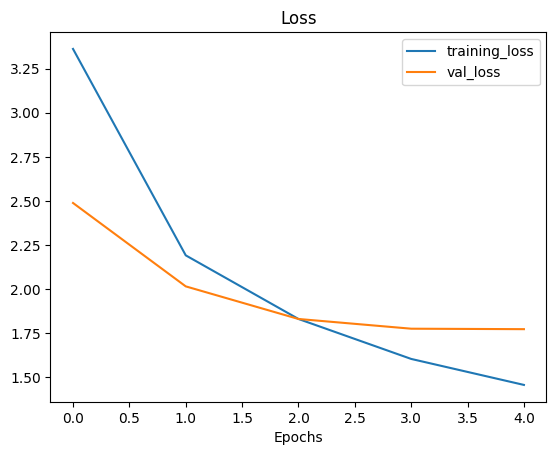

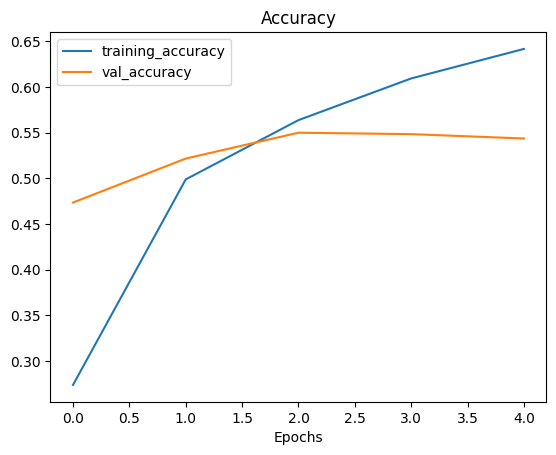

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

>** 🤔 Question: **What do these curves suggest? Hint: ideally, the two curves should be very similar to each other, if not it may suggest that our model is overfitting (performing too well on the training data and not generalizing to unseen data).

## Fine Tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=["accuracy"]
)

In [ ]:
# What layers in the model are trainable?
for layer in model.layers:
  print(layer.name, layer.trainable)

input_layer True
data_augmentation_layer True
efficientnetb0 True
global_average_polling_2d True
output_layer True


In [ ]:
# Check which layers are trainable in our base model
for layer_number, layer in enumerate(model.layers[2].layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs (feature extraction), this is the total number of epochs we're after (5 + 5 = 10)

# Fine-tune our model
history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)),
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1])

Epoch 5/10
237/237 [==============================] - 48s 155ms/step - loss: 1.2061 - accuracy: 0.6818 - val_loss: 1.7112 - val_accuracy: 0.5588
Epoch 6/10
237/237 [==============================] - 33s 138ms/step - loss: 1.0901 - accuracy: 0.7097 - val_loss: 1.7042 - val_accuracy: 0.5572
Epoch 7/10
237/237 [==============================] - 33s 139ms/step - loss: 1.0003 - accuracy: 0.7358 - val_loss: 1.7192 - val_accuracy: 0.5553
Epoch 8/10
237/237 [==============================] - 34s 142ms/step - loss: 0.9443 - accuracy: 0.7502 - val_loss: 1.7079 - val_accuracy: 0.5575
Epoch 9/10
237/237 [==============================] - 33s 138ms/step - loss: 0.8783 - accuracy: 0.7641 - val_loss: 1.6898 - val_accuracy: 0.5612
Epoch 10/10
237/237 [==============================] - 31s 129ms/step - loss: 0.8373 - accuracy: 0.7795 - val_loss: 1.7078 - val_accuracy: 0.5625


In [ ]:
# Evaluate on the whole test dataset
all_classes_10_percent_fine_tune_results = model.evaluate(test_data)
all_classes_10_percent_fine_tune_results

790/790 [==============================] - 74s 94ms/step - loss: 1.5157 - accuracy: 0.5996


[1.5156961679458618, 0.5996435880661011]

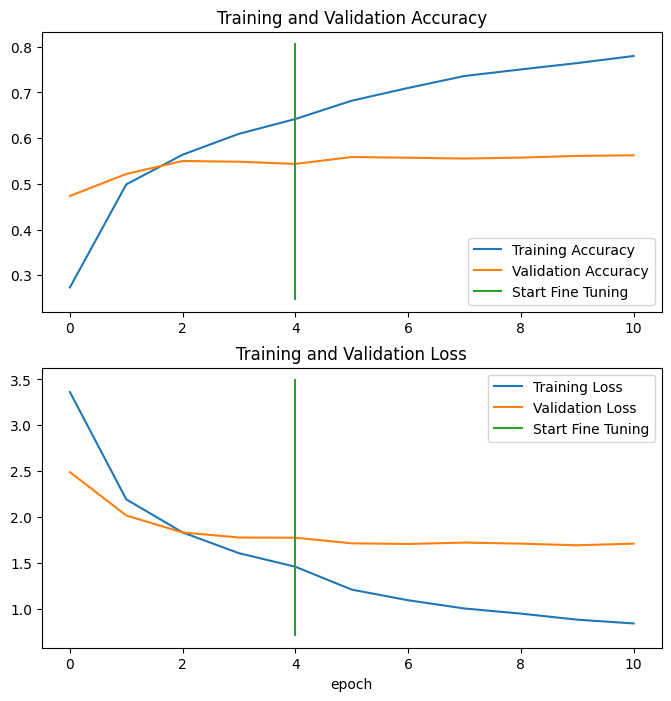

In [ ]:
# Compare the histories of feature extraction model with fine-tuning model
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

transfer learning